## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Input

In [2]:
gt = pd.read_csv("input/gt.csv", index_col=False)
gt

,x,y,w,h,c
0,10,0,100,100,1
1,200,300,95,200,1
2,1000,500,250,300,1
3,700,500,98,112,1
4,690,212,102,108,1


In [3]:
pred = pd.read_csv("input/pred.csv", index_col=False)
pred

,x,y,w,h,c,conf
0,710,530,83,92,1,0.4
1,653,250,79,94,1,0.6
2,205,310,100,196,1,0.7
3,1020,490,200,312,1,0.5
4,123,463,335,1023,1,0.8
5,463,230,1020,350,1,0.3
6,5,7,101,103,1,0.9


In [4]:
pred = pred.sort_values('conf', ascending=False)
pred

,x,y,w,h,c,conf
6,5,7,101,103,1,0.9
4,123,463,335,1023,1,0.8
2,205,310,100,196,1,0.7
1,653,250,79,94,1,0.6
3,1020,490,200,312,1,0.5
0,710,530,83,92,1,0.4
5,463,230,1020,350,1,0.3


In [5]:
def get_segments(df):
    x_segments = [df['x'], df['x'] + df['w']]
    y_segments = [df['y'], df['y'] + df['h']]
    return np.array([x_segments, y_segments]).transpose(0, 2, 1)

In [6]:
get_segments(pred)

array([[[   5,  106],
        [ 123,  458],
        [ 205,  305],
        [ 653,  732],
        [1020, 1220],
        [ 710,  793],
        [ 463, 1483]],

       [[   7,  110],
        [ 463, 1486],
        [ 310,  506],
        [ 250,  344],
        [ 490,  802],
        [ 530,  622],
        [ 230,  580]]], dtype=int64)

In [7]:
get_segments(gt)

array([[[  10,  110],
        [ 200,  295],
        [1000, 1250],
        [ 700,  798],
        [ 690,  792]],

       [[   0,  100],
        [ 300,  500],
        [ 500,  800],
        [ 500,  612],
        [ 212,  320]]], dtype=int64)

In [8]:
def get_intersection(source, target):
    # Horizontal segments intersection
    x_intersection = get_segment_intersection(source[0], target[0])

    # Vertical segments intersection
    y_intersection = get_segment_intersection(source[1], target[1])

    return x_intersection * y_intersection

def get_segment_intersection(source, target):
    source_exp = np.expand_dims(source, axis=1).repeat(len(target), axis=1)
    target_exp = np.expand_dims(target, axis=0).repeat(len(source), axis=0)

    # Get the Cartesian product of input segments (each with each)
    pairs = np.array([source_exp, target_exp])
    pairs = pairs.transpose(1, 2, 0, 3)

    # Left and right limits of each pair
    l, r = pairs[..., 0], pairs[..., 1]

    return np.clip(np.min(r, axis=2) - np.max(l, axis=2), 0, None)

In [9]:
get_intersection(get_segments(pred), get_segments(gt))

array([[ 8928,     0,     0,     0,     0],
       [    0,  3515,     0,     0,     0],
       [    0, 17100,     0,     0,     0],
       [    0,     0,     0,     0,  2940],
       [    0,     0, 60000,     0,     0],
       [    0,     0,     0,  6806,     0],
       [    0,     0, 20000,  7840,  9180]], dtype=int64)

In [10]:
def get_areas(df):
    return np.array(df['w'] * df['h'])

In [11]:
get_areas(pred)

array([ 10403, 342705,  19600,   7426,  62400,   7636, 357000],
      dtype=int64)

In [12]:
get_areas(gt)

array([10000, 19000, 75000, 10976, 11016], dtype=int64)

In [13]:
def get_union(source, target, intersection):
    source_exp = np.expand_dims(source, axis=1).repeat(len(target), axis=1)
    target_exp = np.expand_dims(target, axis=0).repeat(len(source), axis=0)
    return target_exp + source_exp - intersection

In [14]:
def get_ious(source, target):
    # Get intersection areas
    source_segments = get_segments(source)
    target_segments = get_segments(target)
    intersection = get_intersection(source_segments, target_segments)

    # Get union areas
    source_areas = get_areas(source)
    target_areas = get_areas(target)
    union = get_union(source_areas, target_areas, intersection)

    return intersection / union.astype('float32')

In [15]:
ious = get_ious(pred, gt)
ious

array([[0.77803922, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00981323, 0.        , 0.        , 0.        ],
       [0.        , 0.79534884, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.18965295],
       [0.        , 0.        , 0.7751938 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.57648653, 0.        ],
       [0.        , 0.        , 0.04854369, 0.02176955, 0.02558272]])

In [16]:
df = pred[['conf']].copy()
df['gt'] = np.argmax(ious, axis=1)
df['iou'] = np.max(ious, axis=1)
df['dup'] = df.duplicated('gt')
df

,conf,gt,iou,dup
6,0.9,0,0.778039,False
4,0.8,1,0.009813,False
2,0.7,1,0.795349,True
1,0.6,4,0.189653,False
3,0.5,2,0.775194,False
0,0.4,3,0.576487,False
5,0.3,2,0.048544,True


In [17]:
def evaluate(df, gt, iou_threshold):
    df_res = df.copy()

    positive = (df_res['iou'] > iou_threshold) & ~df_res['dup']
    df_res['positive'] = positive

    positive_cumsum = df_res['positive'].cumsum()
    df_res['precision'] = positive_cumsum / np.arange(1, len(df_res) + 1)
    df_res['recall'] = positive_cumsum / len(gt)

    return df_res.reset_index()

In [38]:
def get_pr_curve(df):
    # Extension identifier
    x = list(df['recall'])
    y = list(df['precision'])
    e = [False] * len(df)

    # Left continuation
    if df['positive'].iloc[0]:
        x = [0.0] + x
        y = [1.0] + y
        e = [True] + e

    # Right continuation
    x_last = df['recall'].iloc[-1]
    if x_last < 1.0:
        x += [x_last, 1.0]
        y += [0.0, 0.0]
        e += [True, True]

    return pd.DataFrame({'r': x, 'p': y, 'ext': e})

def draw_pr_curve(df, iou_threshold, file=None):
    plt.figure(figsize=(10, 10))
    plt.plot(df['r'], df['p'], '-go', markevery=np.arange(len(df))[~df['ext']], linewidth=2.0)
    plt.grid()
    plt.title(f'PR curve; IoU > {iou_threshold}', fontsize=20)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    if file is not None:
        plt.savefig(file, dpi=300, bbox_inches='tight')
    plt.show()

def save_pr_curve(df, file):
    df[['recall', 'precision']].to_csv(file, header=['r', 'p'], index=False)

## $AP_{0.5}$

In [24]:
df_05 = evaluate(df, gt, 0.5)
df_05

,index,conf,gt,iou,dup,positive,precision,recall
0,6,0.9,0,0.778039,False,True,1.000000,0.2
1,4,0.8,1,0.009813,False,False,0.500000,0.2
2,2,0.7,1,0.795349,True,False,0.333333,0.2
3,1,0.6,4,0.189653,False,False,0.250000,0.2
4,3,0.5,2,0.775194,False,True,0.400000,0.4
5,0,0.4,3,0.576487,False,True,0.500000,0.6
6,5,0.3,2,0.048544,True,False,0.428571,0.6


In [25]:
save_pr_curve(df_05, "output/prcurve05.csv")

In [35]:
df_05_pr_curve = get_pr_curve(df_05)
df_05_pr_curve

,r,p,ext
0,0.0,1.000000,True
1,0.2,1.000000,False
2,0.2,0.500000,False
3,0.2,0.333333,False
4,0.2,0.250000,False
5,0.4,0.400000,False
6,0.6,0.500000,False
7,0.6,0.428571,False
8,0.6,0.000000,True
9,1.0,0.000000,True


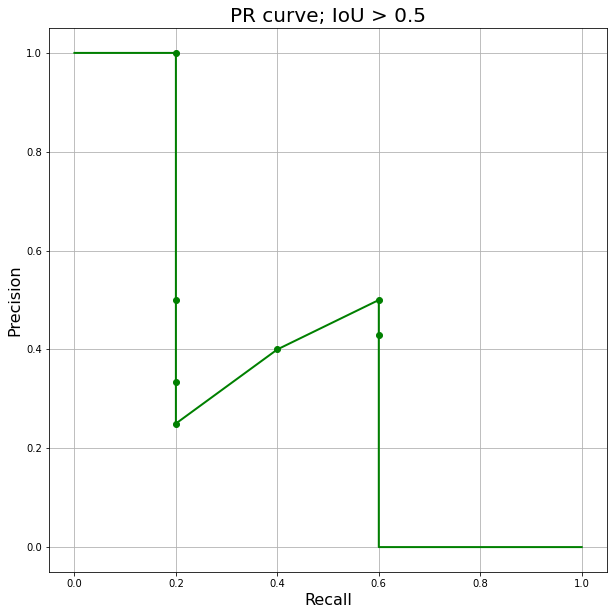

In [39]:
draw_pr_curve(df_05_pr_curve, 0.5, file="output/prcurve05.png")